In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

DATA_DIR = os.path.join("data_raw")
FORK_DIR = os.path.join(DATA_DIR, "forklift", "Lithium-ion battery degradation dataset based on a realistic forklift operation profile")


def convert_size(size_bytes):
    # Convert bytes to KB, MB, GB, TB
    power = 1024
    size_types = ["B", "KB", "MB", "GB", "TB"]
    size = size_bytes / power
    i = 0
    while size >= power:
        size /= power
        i += 1
    return "{:.2f} {}".format(size, size_types[i])


In [5]:
CELL = 1
CELL_DIR = os.path.join(FORK_DIR, f"Cell{CELL}")

rounds = os.listdir(CELL_DIR)
rounds.sort()
rpt = pd.DataFrame()
age = pd.DataFrame()
for r in tqdm(rounds[:None], "Reading files"):
    csv_files = os.listdir(os.path.join(CELL_DIR, r))
    if (n := "RPT.csv") in csv_files:
        rpt = pd.concat([rpt, pd.read_csv(os.path.join(CELL_DIR, r, n))])
    if (n := "Ageing.csv") in csv_files:
        age = pd.concat([age, pd.read_csv(os.path.join(CELL_DIR, r, n))])

display(rpt)
display(age)
print(f"RPT: {convert_size(rpt.memory_usage(deep=True).sum())}")
print(f"AGE: {convert_size(age.memory_usage(deep=True).sum())}")


Reading files: 100%|██████████| 58/58 [00:28<00:00,  2.06it/s]


,Cell,Round,Time,Current,Voltage,Energy,Temperature
0,1,0,0.150,0.0,3.3378,0.0000,24.754
1,1,0,1.178,0.0,3.3378,0.0000,24.754
2,1,0,2.095,0.0,3.3378,0.0000,24.878
3,1,0,12.107,0.0,3.3378,0.0000,24.893
4,1,0,22.105,0.0,3.3378,0.0000,24.863
...,...,...,...,...,...,...,...
94373,1,58,120510.411,0.0,3.3699,226.7208,31.759
94374,1,58,120520.420,0.0,3.3671,226.7208,31.872
94375,1,58,120520.420,0.0,3.3671,226.7208,31.872
94376,1,58,120520.440,0.0,3.3671,226.7208,31.872


,Cell,Round,Part,Time,Current,Voltage,Energy,Temperature
0,1,1,1.0,0.000,0.0000,3.3383,0.0000,44.862
1,1,1,1.0,3.133,-2.9977,3.3378,-0.0027,44.892
2,1,1,1.0,4.126,-20.9992,3.3341,-0.0200,44.892
3,1,1,1.0,5.146,-44.9995,3.3289,-0.0605,44.847
4,1,1,1.0,6.120,-32.9985,3.3305,-0.0885,44.847
...,...,...,...,...,...,...,...,...
589041,1,58,2.0,593140.143,19.9997,3.3355,134.7707,43.930
589042,1,58,2.0,593141.119,19.9997,3.3355,134.7895,43.930
589043,1,58,2.0,593142.128,19.9980,3.3355,134.8075,43.930
589044,1,58,2.0,594053.154,-0.0017,3.3102,134.8121,43.939


RPT: 344.68 KB
AGE: 2.04 MB


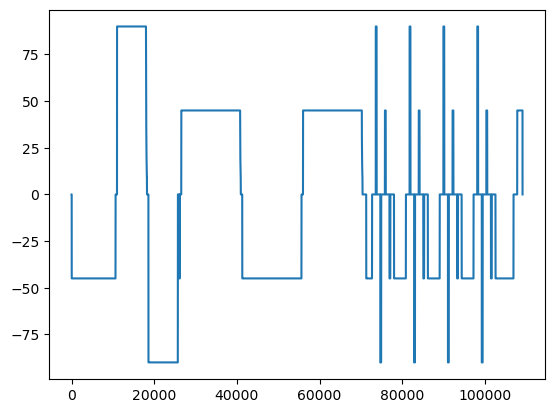

In [60]:
base = rpt
r = 5
df = base[base["Round"] == r]

fig, ax = plt.subplots()

ax.plot(df["Current"])

plt.show()


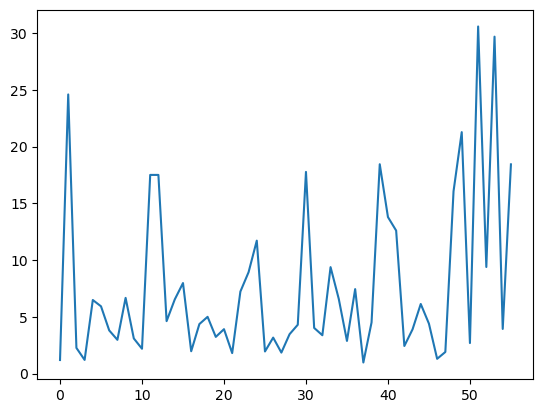

In [15]:
base = age
events = np.sort(base["Round"].unique())
ranges = np.array([])
for r in events:
    df = base[base["Round"] == r]
    ranges = np.append(ranges, df["Temperature"].max() - df["Temperature"].min())

fig, ax = plt.subplots()
ax.plot(ranges)